### Project: Amazon pet supplies product reviews sentiment analysis using different models 
### Python version: 3.10.12



In [6]:
import pandas as pd  
import numpy as np
import re
import matplotlib as plt
import seaborn as sns
import json
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

In [7]:
df_raw = pd.read_csv("data.csv")

In [9]:
df = df_raw.copy()

In [10]:
df.head(3)

,overall,reviewText,year_month
0,1.0,I was not happy with product would like to ret...,2016-12
1,1.0,This cd is scratched and it constantly skips. ...,2016-12
2,4.0,It works just fine and repeats when I'm not he...,2016-12


In [9]:
df.shape

(5820802, 3)

In [11]:
df.isnull().sum()

overall          0
reviewText    3928
year_month       0
dtype: int64

In [12]:
df = df.dropna()
print(df.shape)

(5816874, 3)


In [12]:
df.dtypes

overall       float64
reviewText     object
year_month     object
dtype: object

###  classify rating stars < 3 as negative review ("-1")

In [13]:
df.loc[df["overall"] < 3.0, 'overall'] = -1

###  classify rating score > 3 as posotive review ("1")

In [15]:
df.loc[df["overall"] > 3.0, 'overall'] = 1

###  classify rating score = 3 as neutral review ("0")

In [17]:
df.loc[df["overall"] == 3.0, 'overall'] = 0

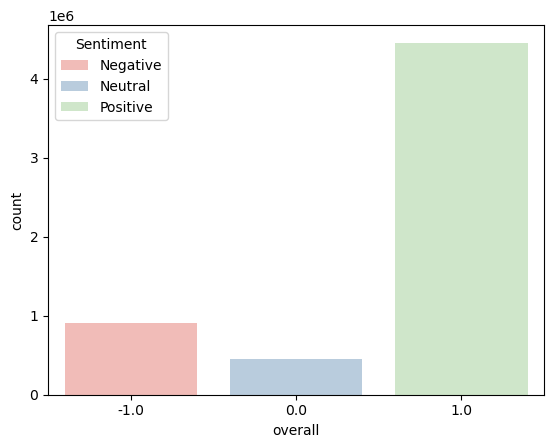

In [19]:
ax = sns.countplot(data=df, x='overall',hue="overall", palette="Pastel1")

handles, labels = ax.get_legend_handles_labels()

new_labels = ['Negative', 'Neutral', 'Positive'] 

ax.legend(handles, new_labels, title='Sentiment')



In [20]:
df[["reviewText"]].head(1)

,reviewText
0,I was not happy with product would like to ret...


In [21]:
def data_preprocess(text):
    text =  RegexpTokenizer(r'\w+|\$[0-9.]+|\d+').tokenize(text.lower())
    text = ' '.join(text)
    return text

In [22]:
df_copy = df.copy()
df_copy['Text'] = df_copy['reviewText'].apply(data_preprocess)
df_copy.head(10)

,overall,reviewText,year_month,Text
0,-1.0,I was not happy with product would like to ret...,2016-12,i was not happy with product would like to ret...
1,-1.0,This cd is scratched and it constantly skips. ...,2016-12,this cd is scratched and it constantly skips d...
2,1.0,It works just fine and repeats when I'm not he...,2016-12,it works just fine and repeats when i m not he...
3,0.0,I purchased this cd for my Pocket Parrot. It h...,2016-12,i purchased this cd for my pocket parrot it ha...
4,0.0,"Maybe it's just my Amazon parrot, but she's no...",2016-10,maybe it s just my amazon parrot but she s not...
5,1.0,I bought this to help me teach my blue quaker ...,2016-09,i bought this to help me teach my blue quaker ...
6,0.0,Bird showed no interest in it....,2016-08,bird showed no interest in it
7,-1.0,did not like at all,2016-08,did not like at all
8,-1.0,Didn't do a thing for my African Grey! He hate...,2016-08,didn t do a thing for my african grey he hated...
9,1.0,I like it - but the Cockatiel I am not so sure...,2016-07,i like it but the cockatiel i am not so sure h...


In [23]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(words):
    words = words.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    words = ' '.join(words)
    return words

In [24]:
review = df_copy.copy()
review['Text1'] = review['Text'].apply(preprocess)
review.head(10)

,overall,reviewText,year_month,Text,Text1
0,-1.0,I was not happy with product would like to ret...,2016-12,i was not happy with product would like to ret...,happy product would like return work
1,-1.0,This cd is scratched and it constantly skips. ...,2016-12,this cd is scratched and it constantly skips d...,cd scratched constantly skip disappointed
2,1.0,It works just fine and repeats when I'm not he...,2016-12,it works just fine and repeats when i m not he...,work fine repeat bird still talking stay quiet...
3,0.0,I purchased this cd for my Pocket Parrot. It h...,2016-12,i purchased this cd for my pocket parrot it ha...,purchased cd pocket parrot woman man speaking ...
4,0.0,"Maybe it's just my Amazon parrot, but she's no...",2016-10,maybe it s just my amazon parrot but she s not...,maybe amazon parrot picking quickly well
5,1.0,I bought this to help me teach my blue quaker ...,2016-09,i bought this to help me teach my blue quaker ...,bought help teach blue quaker named booger tal...
6,0.0,Bird showed no interest in it....,2016-08,bird showed no interest in it,bird showed interest
7,-1.0,did not like at all,2016-08,did not like at all,like
8,-1.0,Didn't do a thing for my African Grey! He hate...,2016-08,didn t do a thing for my african grey he hated...,thing african grey hated obnoxious
9,1.0,I like it - but the Cockatiel I am not so sure...,2016-07,i like it but the cockatiel i am not so sure h...,like cockatiel sure listens far speak


In [26]:
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

text = ' '.join(review['Text1'])  # Joining all 'Text1' entries into a single string
words = text.split()  # Tokenizing the text into words
fd = FreqDist(words)  # Calculating the frequency distribution of words

In [25]:
top_10 = fd.most_common(10)

# Create pandas series to make plotting easier
fdist = pd.Series(dict(top_10))

NameError: name 'fd' is not defined

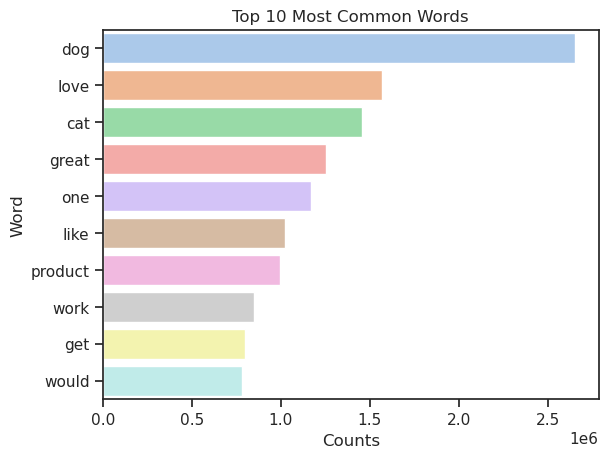

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="ticks")

sns.barplot(y=fdist.index, x=fdist.values, palette='pastel',hue=fdist.index, legend=False).set( title="Top 10 Most Common Words") 

plt.xlabel('Counts')
plt.ylabel('Word')

plt.show()


In [27]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(ngram_range=(2,2))
bigrams = cv.fit_transform(review['Text1'])

In [53]:
import numpy as np
count_values = np.array(bigrams.sum(axis=0)).flatten()
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["Frequency", "Bigram"]

[Text(0.5, 1.0, 'Top 10 Most Common Bigrams')]

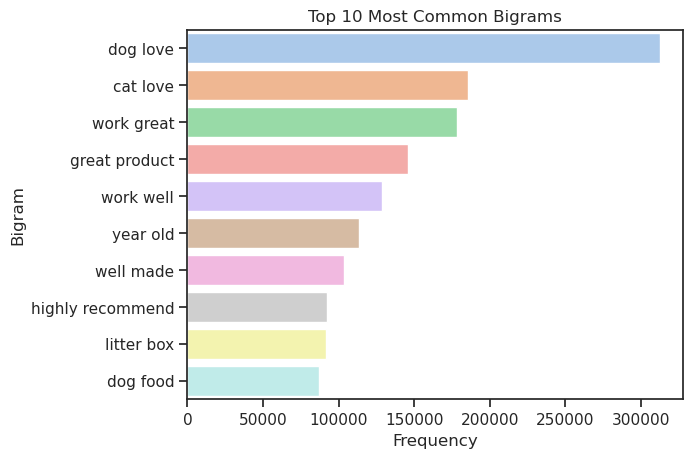

In [60]:
sns.barplot(x=ngram_freq['Frequency'][:10], y=ngram_freq['Bigram'][:10],palette='pastel',hue=ngram_freq['Bigram'][:10], legend=False).set( title='Top 10 Most Common Bigrams')


In [27]:
percentage = 0.1  # 10% (change this value as needed)

sampled_data = review.sample(frac=percentage, random_state=42)  # Randomly sample 10% of the data

In [32]:
# Assuming 'sampled_data' is your DataFrame with columns 'year_month' and 'overall'

grouped_data = sampled_data.groupby(['year_month', 'overall']).size().reset_index(name='count')

# 'grouped_data' will contain the count of occurrences based on 'year_month' and 'overall'
print(grouped_data)




    year_month  overall  count
0      2013-10     -1.0    553
1      2013-10      0.0    376
2      2013-10      1.0   3031
3      2013-11     -1.0    601
4      2013-11      0.0    373
..         ...      ...    ...
178    2018-09      0.0     68
179    2018-09      1.0    750
180    2018-10     -1.0      5
181    2018-10      0.0      1
182    2018-10      1.0      8

[183 rows x 3 columns]


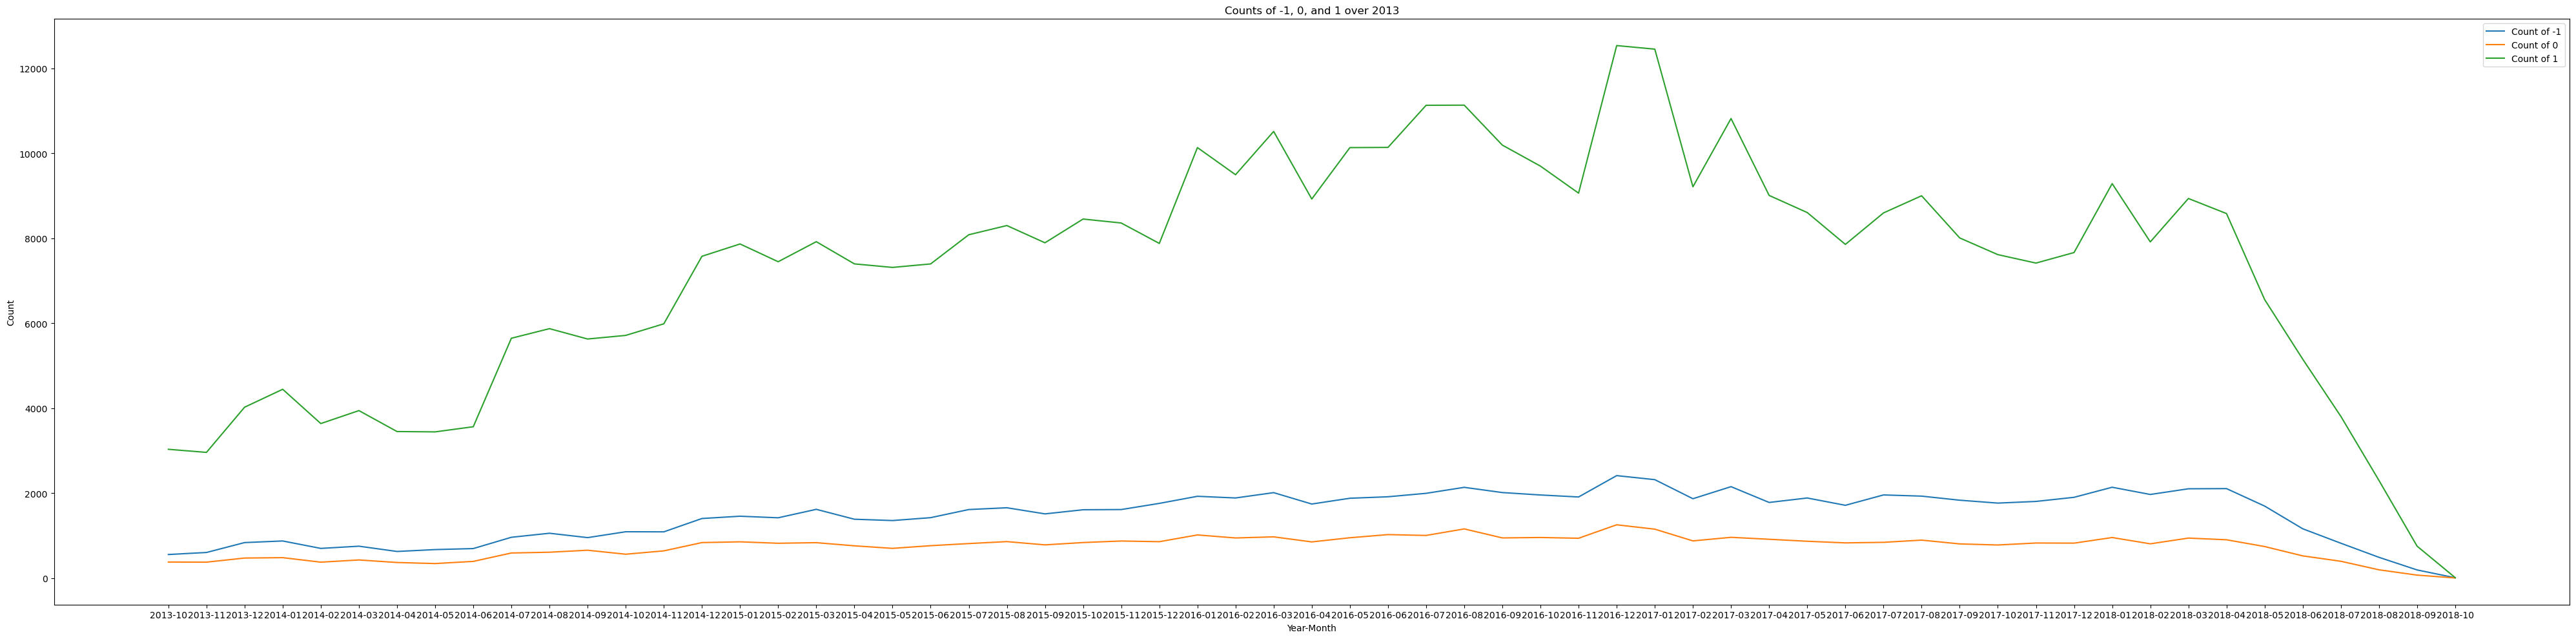

In [53]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'grouped_data' is your DataFrame with columns 'year_month', 'overall', and 'count'

# Filter the data for the year 2013
data_2013 = grouped_data[(grouped_data['year_month'] >= '2013-10') & (grouped_data['year_month'] <= '2018-10')]

# Filter the data for overall values -1, 0, and 1
data_minus_1 = data_2013[data_2013['overall'] == -1]
data_0 = data_2013[data_2013['overall'] == 0]
data_1 = data_2013[data_2013['overall'] == 1]

# Line plots for counts of -1, 0, and 1 over 2013
plt.figure(figsize=(40, 10))

plt.plot(data_minus_1['year_month'], data_minus_1['count'], label='Count of -1')
plt.plot(data_0['year_month'], data_0['count'], label='Count of 0')
plt.plot(data_1['year_month'], data_1['count'], label='Count of 1')

plt.xlabel('Year-Month')
plt.ylabel('Count')
plt.title('Counts of -1, 0, and 1 over 2013')
plt.legend()

plt.tight_layout()

plt.show()


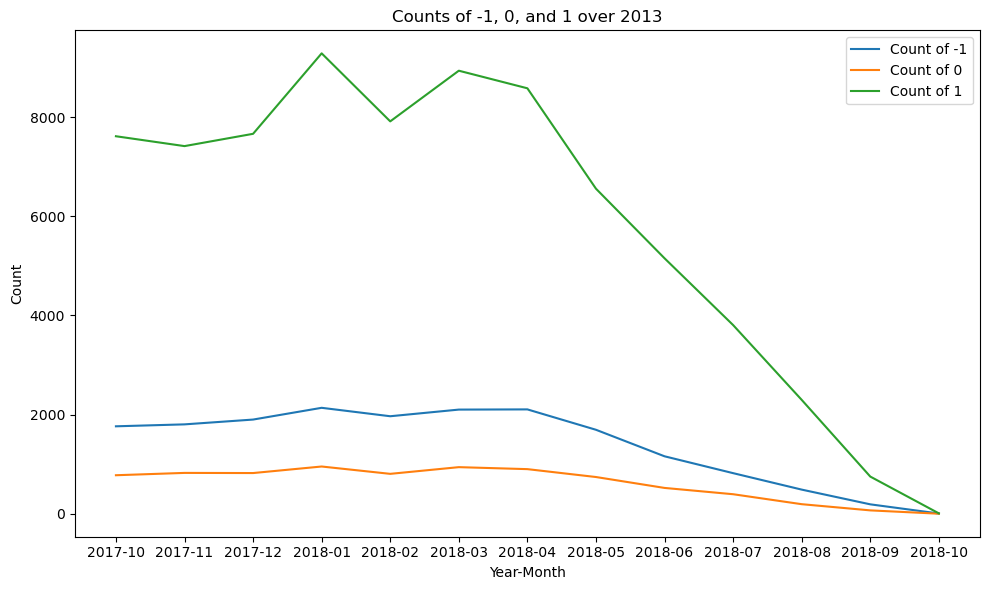

In [45]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'grouped_data' is your DataFrame with columns 'year_month', 'overall', and 'count'

# Filter the data for the year 2013
data_2013 = grouped_data[(grouped_data['year_month'] >= '2017-10') & (grouped_data['year_month'] <= '2018-10')]

# Filter the data for overall values -1, 0, and 1
data_minus_1 = data_2013[data_2013['overall'] == -1]
data_0 = data_2013[data_2013['overall'] == 0]
data_1 = data_2013[data_2013['overall'] == 1]

# Line plots for counts of -1, 0, and 1 over 2013
plt.figure(figsize=(10, 6))

plt.plot(data_minus_1['year_month'], data_minus_1['count'], label='Count of -1')
plt.plot(data_0['year_month'], data_0['count'], label='Count of 0')
plt.plot(data_1['year_month'], data_1['count'], label='Count of 1')

plt.xlabel('Year-Month')
plt.ylabel('Count')
plt.title('Counts of -1, 0, and 1 over 2013')
plt.legend()

plt.tight_layout()

plt.show()


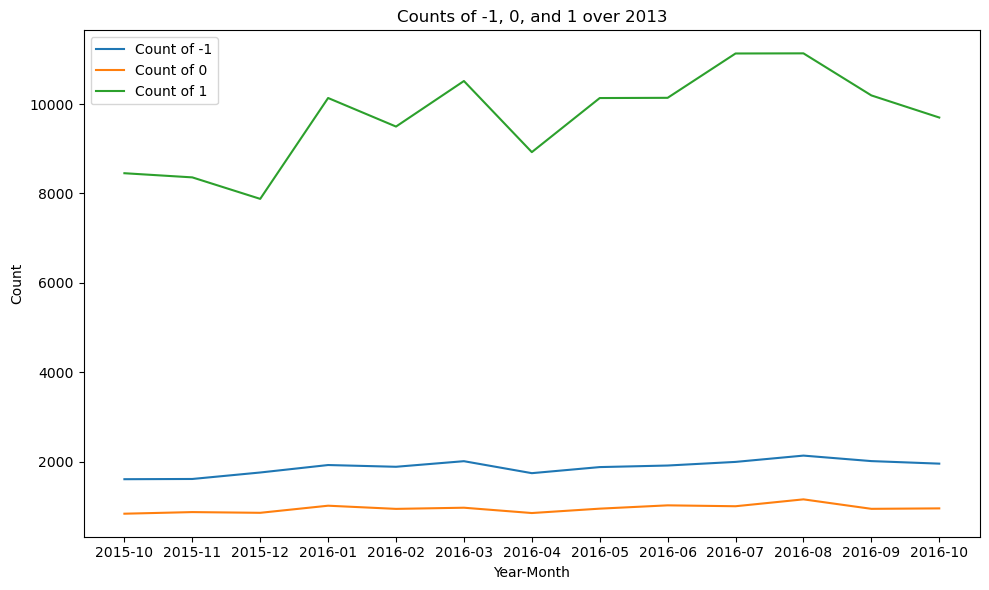

In [47]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'grouped_data' is your DataFrame with columns 'year_month', 'overall', and 'count'

# Filter the data for the year 2013
data_2013 = grouped_data[(grouped_data['year_month'] >= '2015-10') & (grouped_data['year_month'] <= '2016-10')]

# Filter the data for overall values -1, 0, and 1
data_minus_1 = data_2013[data_2013['overall'] == -1]
data_0 = data_2013[data_2013['overall'] == 0]
data_1 = data_2013[data_2013['overall'] == 1]

# Line plots for counts of -1, 0, and 1 over 2013
plt.figure(figsize=(10, 6))

plt.plot(data_minus_1['year_month'], data_minus_1['count'], label='Count of -1')
plt.plot(data_0['year_month'], data_0['count'], label='Count of 0')
plt.plot(data_1['year_month'], data_1['count'], label='Count of 1')

plt.xlabel('Year-Month')
plt.ylabel('Count')
plt.title('Counts of -1, 0, and 1 over 2013')
plt.legend()

plt.tight_layout()

plt.show()


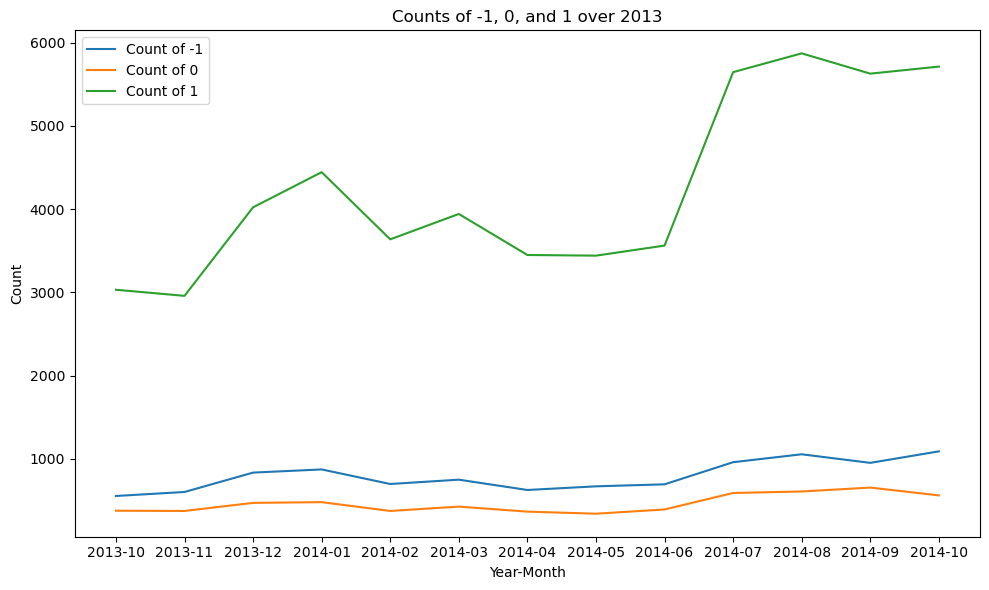

In [48]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'grouped_data' is your DataFrame with columns 'year_month', 'overall', and 'count'

# Filter the data for the year 2013
data_2013 = grouped_data[(grouped_data['year_month'] >= '2013-10') & (grouped_data['year_month'] <= '2014-10')]

# Filter the data for overall values -1, 0, and 1
data_minus_1 = data_2013[data_2013['overall'] == -1]
data_0 = data_2013[data_2013['overall'] == 0]
data_1 = data_2013[data_2013['overall'] == 1]

# Line plots for counts of -1, 0, and 1 over 2013
plt.figure(figsize=(10, 6))

plt.plot(data_minus_1['year_month'], data_minus_1['count'], label='Count of -1')
plt.plot(data_0['year_month'], data_0['count'], label='Count of 0')
plt.plot(data_1['year_month'], data_1['count'], label='Count of 1')

plt.xlabel('Year-Month')
plt.ylabel('Count')
plt.title('Counts of -1, 0, and 1 over 2013')
plt.legend()

plt.tight_layout()

plt.show()
